In [159]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 

import nltk
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize

from sklearn.feature_extraction.text import TfidfVectorizer 

from sklearn.model_selection import train_test_split

from sklearn.linear_model import LassoCV
from sklearn.metrics import classification_report

from sklearn.model_selection import cross_val_score

path_name = 'your_path_name_here/mental_health.csv'
df=pd.read_csv(path_name)
print(df)

df = df.drop_duplicates()

#REDUCED SAMPLING
import random
random.seed(1)
size = list(df.index)
sample = random.sample(size,100)
df = df.loc[sample]

#Split the matrix into predictors and response 
msg=df["text"]
msg=msg.str.replace('[^a-zA-Z0-9]+'," h", regex = True) 
y=df['label'].values
y 


#Stemming and Tokenising
stemmer=PorterStemmer()
msg=msg.apply(lambda line:[stemmer.stem(token.lower()) for token in word_tokenize(line)]).apply(lambda token:" ".join(token))
msg=msg.apply(lambda line:[token for token in word_tokenize(line) if len(token)>2]).apply(lambda y:" ".join(y))

#Vectorising
tf=TfidfVectorizer() 
data_vec=tf.fit_transform(msg)
np.shape(data_vec)

#Train, Validation, and Test Split ###RANDOMSTATE=1###
from sklearn.model_selection import train_test_split
#test_size=0.3 implies 70% will be used to training and 30% for testing. 
#random_state sets seed for random number generator, ensuring reducibility
x_train,x_test,y_train,y_test=train_test_split(data_vec,y,test_size=0.3,random_state=1)

                                                    text  label
0      dear american teens question dutch person hear...      0
1      nothing look forward lifei dont many reasons k...      1
2      music recommendations im looking expand playli...      0
3      im done trying feel betterthe reason im still ...      1
4      worried  year old girl subject domestic physic...      1
...                                                  ...    ...
27972  posting everyday people stop caring  religion ...      0
27973  okay definetly need hear guys opinion ive pret...      0
27974  cant get dog think ill kill myselfthe last thi...      1
27975  whats point princess bridei really think like ...      1
27976  got nudes person might might know snapchat do ...      0

[27977 rows x 2 columns]


/Users/tobyokeefe/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/tobyokeefe/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/tobyokeefe/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/tobyokeefe/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/tobyokeefe/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/tobyokeefe/opt/anaconda3/lib/python3.9/site-pack

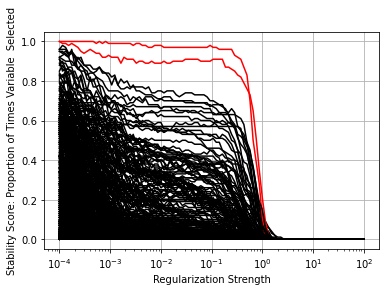

In [167]:
from sklearn.linear_model import LogisticRegression
from sklearn.utils import resample

def lasso_stability_path(X, Y, n_resamples=100, alphas=np.logspace(-4, 2, 100), cv=5):
    n_features = X.shape[1]
    n_alphas = len(alphas)
    coefs = np.zeros((n_alphas, n_features))
    sample = np.zeros((n_alphas, n_features))
    
    for i in range(n_resamples):
        X_resampled, Y_resampled = resample(X, Y)
        for j in range(n_alphas): 
            modelLR_lasso = LogisticRegression(penalty='l1', C = 1/alphas[j], random_state=1, solver='liblinear', max_iter=1000)
            model = modelLR_lasso.fit(X_resampled, Y_resampled)
            coefs[j,:] = (np.abs(model.coef_)>0)
        sample += coefs         
    
    sample /= n_resamples
    return alphas, sample

# Compute stability path
alphas, sample = lasso_stability_path(x_train, y_train)

# Calculate AUSP
AUSP = np.trapz(sample, x=alphas, axis=0)

# Find indices of features with top 5 AUSP values
top_indices = np.argsort(AUSP)[-2:]

# Plot stability path
plt.figure((figsize=(10,8)))
for i in range(sample.shape[1]):
    if i in top_indices:
        plt.plot(alphas, sample[:, i], color='red')
    else:
        plt.plot(alphas, sample[:, i], color='black')

plt.xscale('log')
plt.xlabel('Regularization Strength')
plt.ylabel('Stability Score: Proportion of Times Variable  Selected')
plt.grid(True)
#plt.savefig("L1-Stability-Path.pdf", bbox_inches="tight")
plt.show()
